In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.signal as signal

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression

import joblib


# Load dataset

ECG's metadata

In [214]:
ecgHeaders = [
	"sample",
	"LI", 
	"LII", 
	"LIII", 
	"aVR", 
	"aVL",
	"aVF", 
	"V1",
	"V2",
	"V3",
	"V4",
	"V5",
	"V6"
]


ecgFeatures = [
	"LI", 
	"aVF", 
	"V2"
]

ecgTarget = [
	"LII", 
	"LIII", 
	"aVR", 
	"aVL",
	"V1",
	"V3",
	"V4",
	"V5",
	"V6"
]


In [215]:
ecgPlotHeaders = [
    "LI", "aVR", "V1", "V4",
	"LII", "aVL", "V2", "V5",
	"LIII", "aVF", "V3", "V6"
]

ecgPlotColors = {
	"LI": "seagreen",
	"aVR": "black",
	"V1": "gold",
	"V4": "orangered",
	"LII": "cornflowerblue",
	"aVL": "seagreen",
	"V2": "gold",
	"V5": "crimson",
	"LIII": "cornflowerblue",
	"aVF": "cornflowerblue",
	"V3": "orangered",
	"V6": "crimson"
}

ECG's labels

In [216]:
ecgsDataset = []

with open("../ecgs/labels/RECORDS-acceptable") as file:
	ecgsDataset = map(
		lambda ecgName: ecgName.strip(), 
		file.readlines()
	)
	ecgsDataset = list(ecgsDataset) 

	print("Quantidade de ECG's disponíveis:", len(ecgsDataset))

Quantidade de ECG's disponíveis: 773


Split dataset

In [217]:
trainEcgs, validationEcgs = train_test_split(
	ecgsDataset, 
	train_size = .70, 
	test_size = .30
)

print("Quantidade de ECG para treinamento:", len(trainEcgs))
print("Quantidade de ECG para validação:", len(validationEcgs))

Quantidade de ECG para treinamento: 541
Quantidade de ECG para validação: 232


# Preprocessing Dataset

Making the highpass butter filter

In [218]:
order = 2
fc = 1
fs = 500

b, a = signal.butter(
	N = order,
	Wn = fc,
	btype = "highpass",
	fs = fs
)

print("Numerador: ", b)
print("Denominador: ", a)

Numerador:  [ 0.9911536  -1.98230719  0.9911536 ]
Denominador:  [ 1.         -1.98222893  0.98238545]


Filtering and crop 

In [219]:
def preprocessing(ecgDf):
	ecgFiltred = ecgDf.apply(
		lambda serie: 2.5 * signal.filtfilt(b, a, serie), 
		axis = 0
	)
	ecgCroped = ecgFiltred.iloc[500: -500]

	return ecgCroped

In [220]:
xTrainAll = []
yTrainAll = []

for trainEcgFile in trainEcgs:
	ecgDf = pd.read_csv(
		filepath_or_buffer = f"../ecgs/set-a/{trainEcgFile}.txt",
		names = ecgHeaders,
		index_col = 0
	)

	ecgDf = preprocessing(ecgDf)

	xTrain = ecgDf[ecgFeatures]
	yTrain = ecgDf[ecgTarget]
	
	xTrainAll.extend(xTrain.values)
	yTrainAll.extend(yTrain.values)

	del ecgDf

xTrainAll = np.array(xTrainAll)
yTrainAll = np.array(yTrainAll)


In [221]:
xValidationAll = []
yValidationAll = []

for validationEcgFile in validationEcgs:
	ecgDf = pd.read_csv(
		filepath_or_buffer = f"../ecgs/set-a/{validationEcgFile}.txt",
		names = ecgHeaders,
		index_col = 0
	)

	ecgDf = preprocessing(ecgDf)

	xValidation = ecgDf[ecgFeatures]
	yValidation = ecgDf[ecgTarget]

	xValidationAll.extend(xValidation.values)
	yValidationAll.extend(yValidation.values)

	del ecgDf

xValidationAll = np.array(xValidationAll)
yValidationAll = np.array(yValidationAll)

Normalization

In [222]:
scaler = StandardScaler()

In [223]:
xTrainScaled = scaler.fit_transform(xTrainAll)
xValidationScaled = scaler.transform(xValidationAll)

# Training

In [224]:
linearModel = LinearRegression()

In [225]:
linearModel.fit(xTrainScaled, yTrainAll)

LinearRegression()

In [226]:
print("Coeficientes: ")
print(np.round(linearModel.coef_, 3))
print(np.round(linearModel.intercept_, 3))

Coeficientes: 
[[ 1.46978e+02 -1.34157e+02 -7.30000e-02]
 [ 7.28820e+01 -1.34157e+02 -7.30000e-02]
 [-1.09961e+02  6.66900e+01  6.90000e-02]
 [ 1.09576e+02 -1.34044e+02 -1.02000e-01]
 [-5.98670e+01  2.38910e+01  6.20130e+01]
 [ 9.05360e+01 -9.25360e+01  8.31740e+01]
 [ 1.47676e+02 -1.26693e+02  4.53310e+01]
 [ 1.41200e+02 -1.10149e+02  1.54820e+01]
 [ 1.25177e+02 -1.01005e+02 -4.01300e+00]]
[-0.004 -0.033 -0.013 -0.018 -0.133 -0.132 -0.15  -0.255  0.365]


# Validation

In [227]:
yPredicted = linearModel.predict(xValidationScaled)

mseValidation = mean_squared_error(
	y_true = yValidationAll, 
	y_pred = yPredicted,
	multioutput = "raw_values"
)
mseValidation = np.round(mseValidation)
mseValidation = mseValidation.tolist()

print("MSE Labels: ", ecgTarget)
print("MSE Values:", mseValidation)

MSE Labels:  ['LII', 'LIII', 'aVR', 'aVL', 'V1', 'V3', 'V4', 'V5', 'V6']
MSE Values: [2.0, 2.0, 1.0, 3.0, 53802.0, 339907.0, 131370.0, 34203.0, 59423.0]


# Ploting

In [228]:
def plotECG(ecg, headers, colors): 
	figure, axes = plt.subplots(
		nrows = 3,
		ncols = 4,
		sharex = True,
		figsize = (16, 9)
	)

	figure.suptitle("ECG 12-Lead")
	figure.supxlabel("Amostra")
	figure.supylabel("Dpp")

	axes = axes.flatten()

	for idx, header in enumerate(headers):
		axes[idx].plot(ecg[header], color = colors[header])
		axes[idx].set_title(f"{header}")
	

	plt.tight_layout(pad = 1.5)

	plt.show()

	plt.close()

In [229]:
def comparativeFullEcgPlot(ecgOring, ecgRec, headers):
	figure, axes = plt.subplots(
		nrows   = 3,
		ncols   = 4,
		sharex  = True,
		figsize = (16, 9)
	)

	figure.suptitle("Comparação: ECG 12-Lead")
	figure.supxlabel("Amostra")
	figure.supylabel("Dpp")

	axes = axes.flatten()

	for idx, header in enumerate(headers):
		corr = np.round(ecgOring[header].corr(ecgRec[header]), 3)
		rmse = np.round(root_mean_squared_error(ecgOring[header], ecgRec[header]), 3)

		axes[idx].plot(
			ecgOring[header], 
			color = "blue", 
			alpha = 0.75)
		axes[idx].plot(
			ecgRec[header], 
			color = "red", 
			alpha=0.75
		)

		axes[idx].set_title(f"{header} CORR = {corr} RMSE = {rmse}")
	

	plt.tight_layout(pad = 1.5)

	plt.show()

	plt.close()

In [230]:
ecgSampleDf = pd.read_csv(
	filepath_or_buffer = f"./samples/1031414.txt",
	names = ecgHeaders,
	index_col = 0
)

In [231]:
ecgSampleDf = preprocessing(ecgSampleDf)

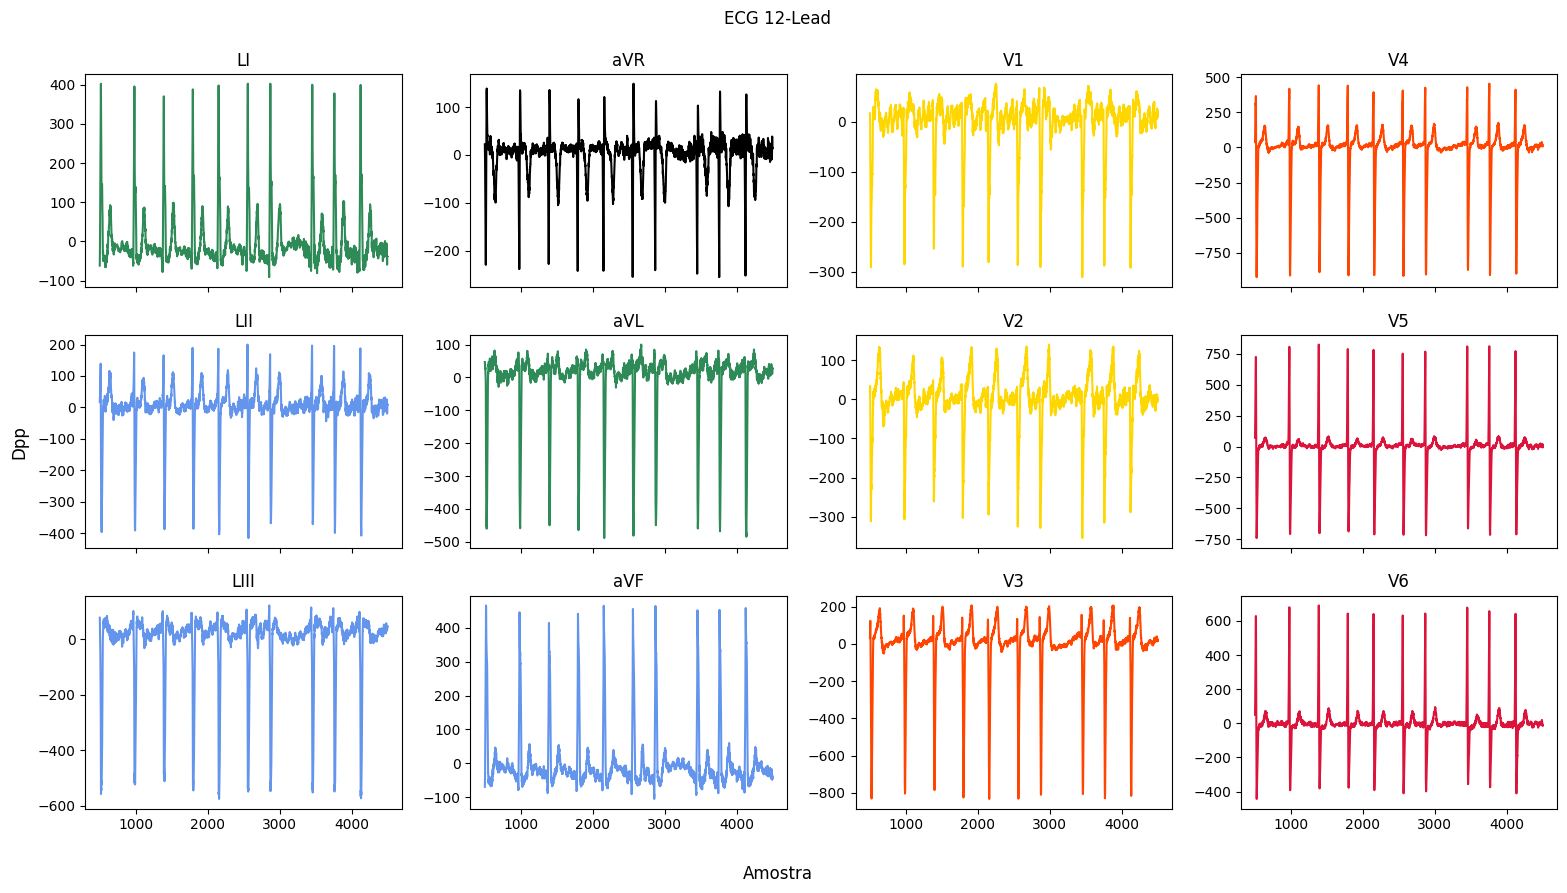

In [232]:
plotECG(
    ecg = ecgSampleDf,  
    headers = ecgPlotHeaders, 
    colors = ecgPlotColors
)

In [233]:
xFeaturesSampleEcgDf = ecgSampleDf[ecgFeatures]
yTargetSampleEcg = ecgSampleDf[ecgTarget].values

ecgSampleTargetPredicted = linearModel.predict(
	X = scaler.transform(
		X = xFeaturesSampleEcgDf.values
	)
)

In [234]:
ecgSampleTargetPredictedDf = pd.DataFrame(
	data = ecgSampleTargetPredicted,
	columns = ecgTarget,
	index = ecgSampleDf.index
)

In [235]:
ecgSampleRecDf = pd.concat([
	xFeaturesSampleEcgDf,
	ecgSampleTargetPredictedDf     
], axis = 1)


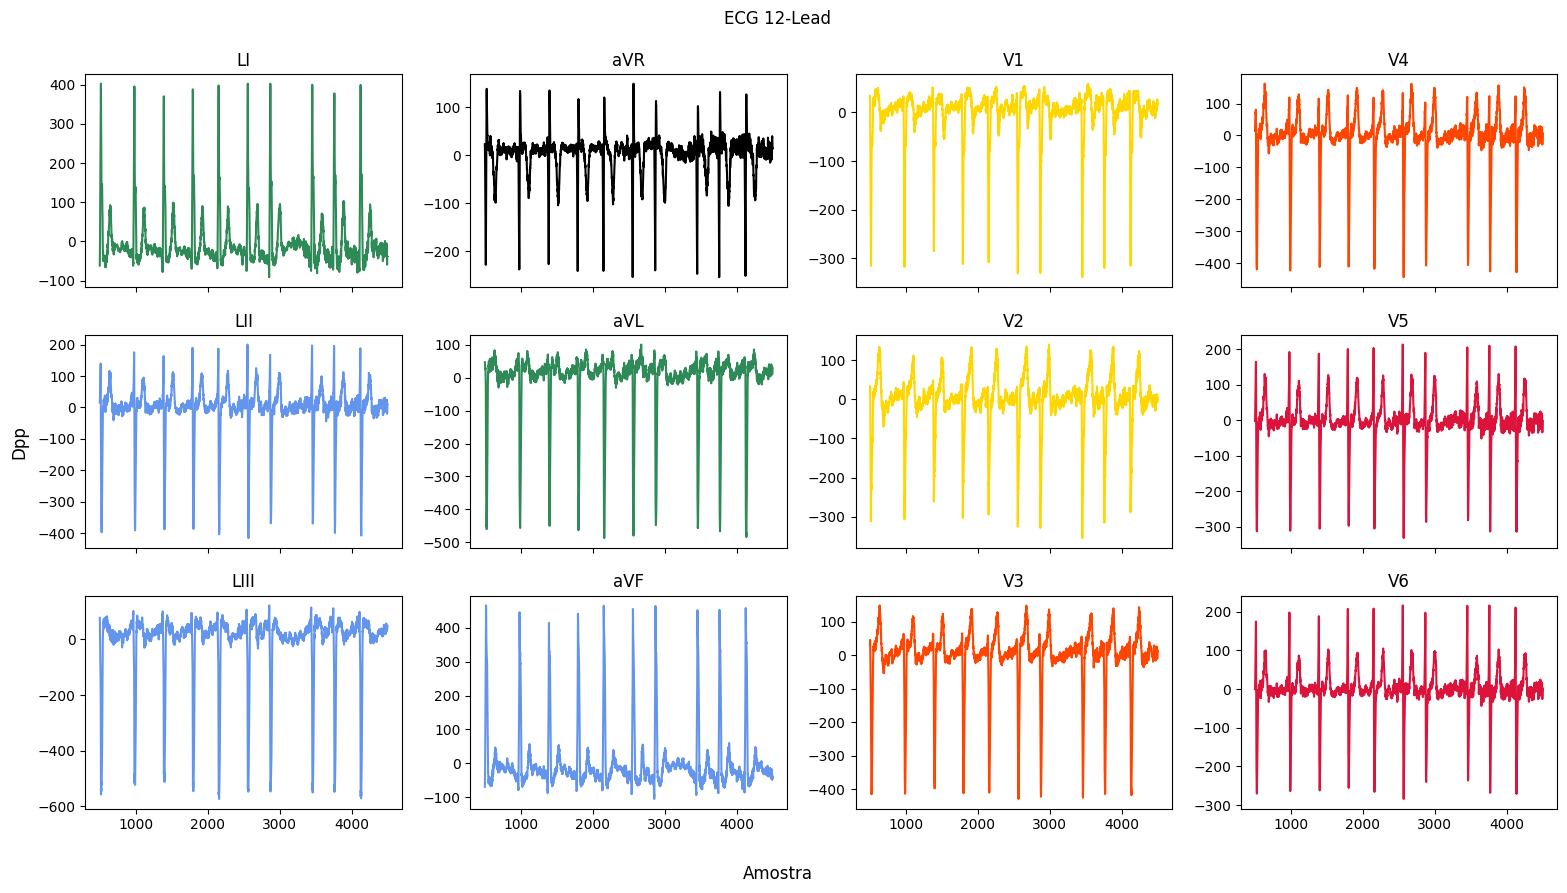

In [236]:
plotECG(
    ecg     = ecgSampleRecDf,
    headers = ecgPlotHeaders,
    colors  = ecgPlotColors
)

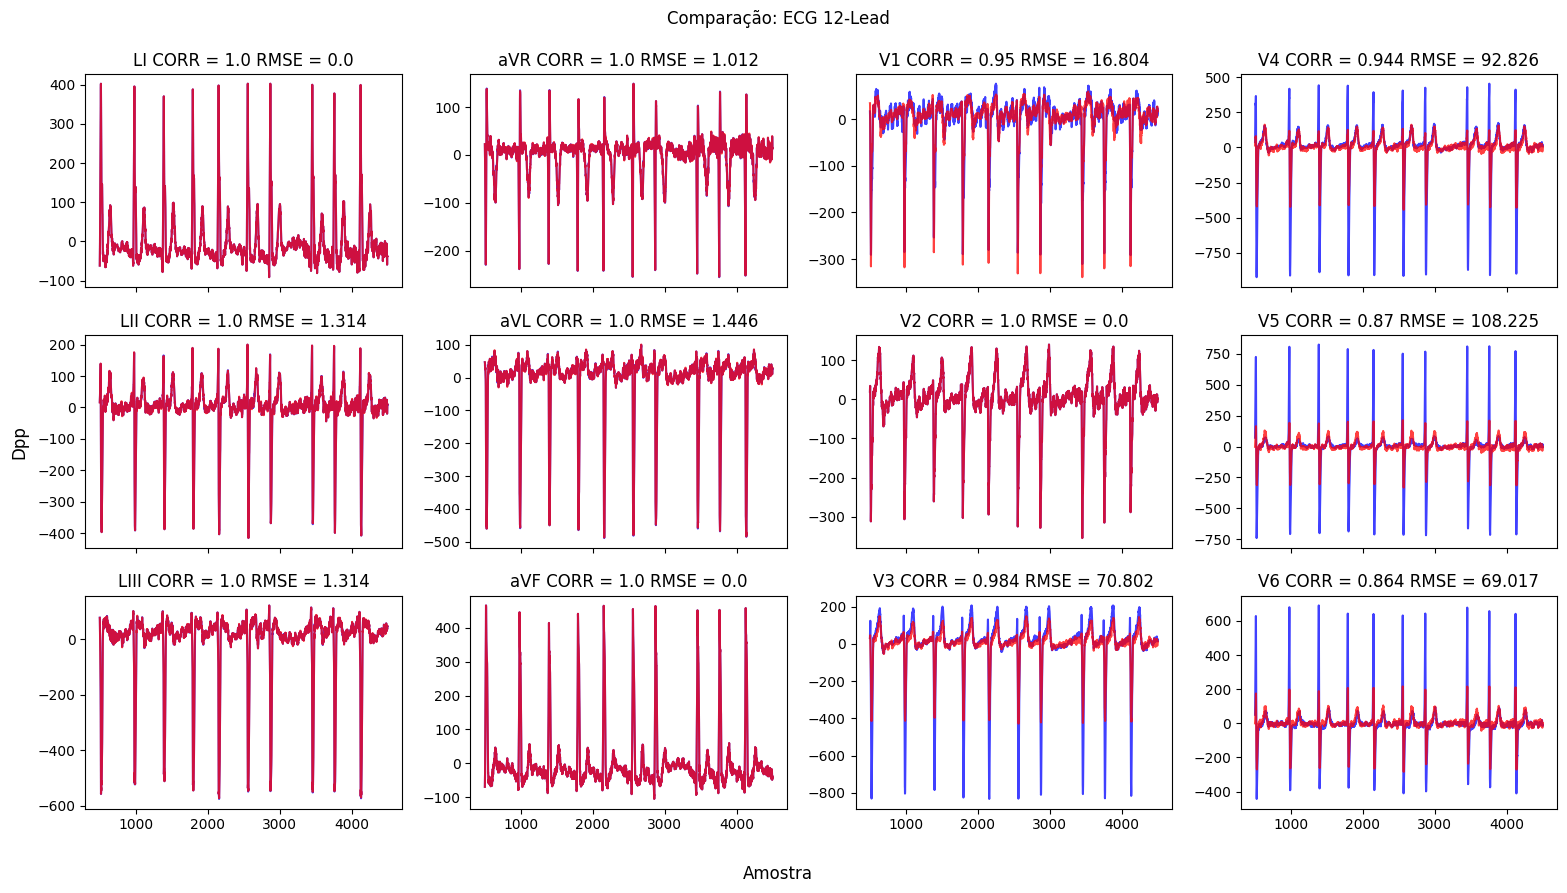

In [237]:
comparativeFullEcgPlot(
	ecgOring = ecgSampleDf,
	ecgRec   = ecgSampleRecDf,
    headers  = ecgPlotHeaders
)

In [238]:
viewport = slice(1000, 1500)

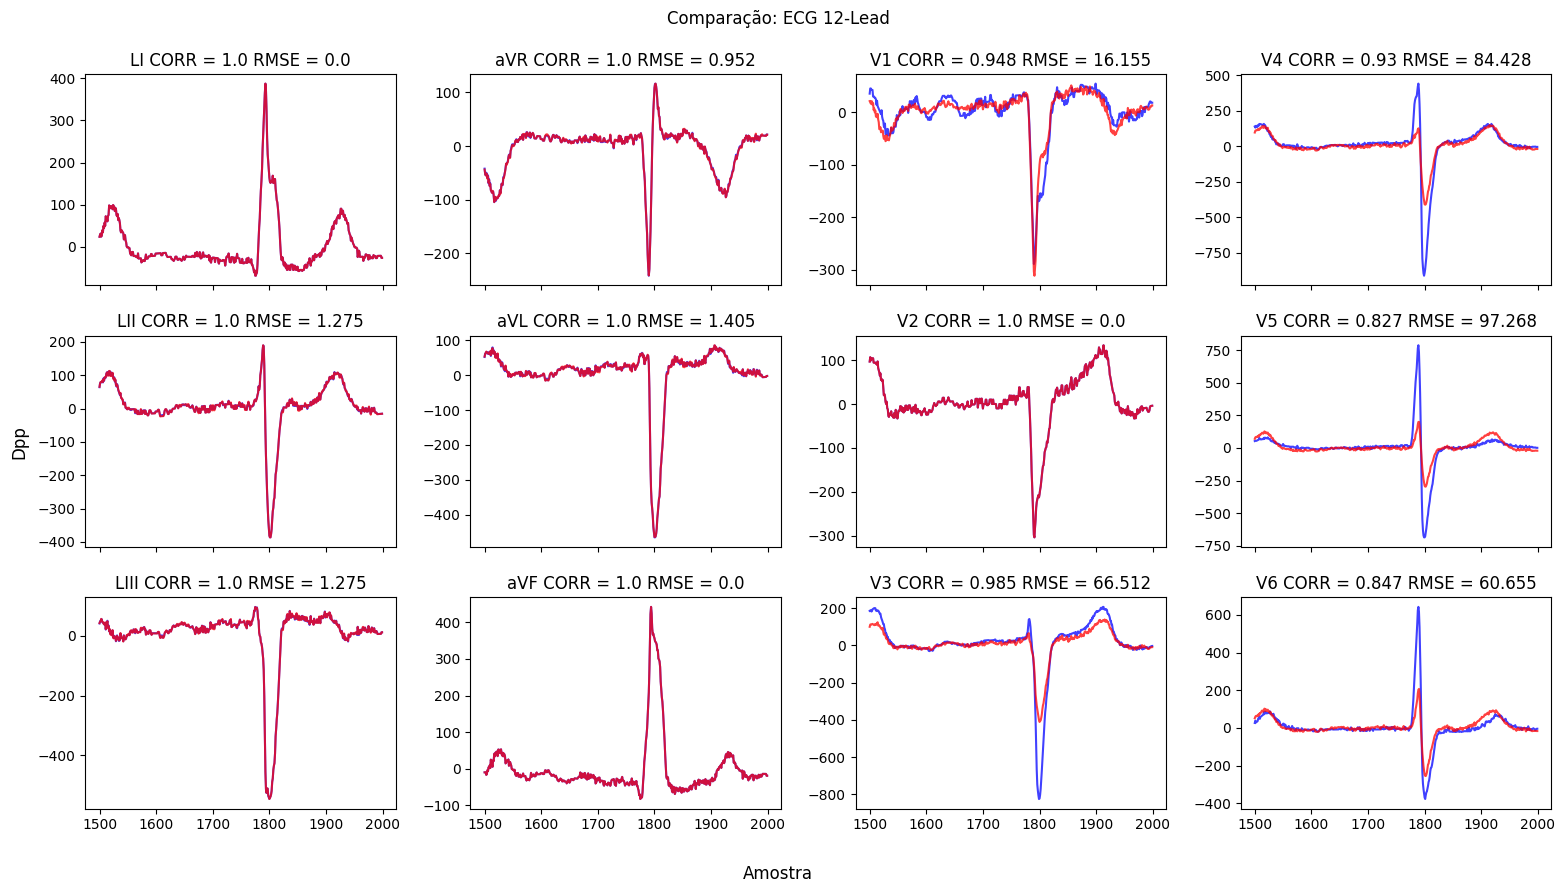

In [239]:
comparativeFullEcgPlot(
	ecgOring = ecgSampleDf[viewport],
	ecgRec   = ecgSampleRecDf[viewport],
    headers  = ecgPlotHeaders
)

# Save Model

In [240]:
joblib.dump(
	value = linearModel,
	filename = "./models/reglin-v0.pkl"
)

joblib.dump(
	value = scaler,
	filename = "./models/reglin-v0.scaler.pkl"
)

['./models/reglin-v0.scaler.pkl']